In [4]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load JSON files
us_json_path = "../resources/usCompanies.json"
foreign_json_path = "../resources/foreignCompanies.json"

with open(us_json_path, "r") as file:
    us_data = json.load(file)

with open(foreign_json_path, "r") as file:
    foreign_data = json.load(file)

In [5]:
# Define the top 5 companies for US and International
top_us_companies = ["AAPL", "NVDA", "MSFT", "AMZN", "GOOG"]
top_international_companies = ["TSM", "SSNLF", "ASML", "TCEHY", "BABA"]

In [6]:
# Filter tickers from JSON
us_tickers = [ticker for ticker in us_data["2017-01-20_2017-12-31"].keys() if ticker in top_us_companies]
foreign_tickers = [ticker for ticker in foreign_data["2017-01-20_2017-12-31"].keys() if ticker in top_international_companies]

In [10]:
# Function to extract price data from JSON (same as before)
def extract_prices(data, tickers, year):
    prices = {}
    for ticker in tickers:
        try:
            first_date = list(data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"].keys())[0]
            last_date = list(data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"].keys())[-1]
            prices[ticker] = {
                "Price Start": data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"][first_date]["Close"],
                "Price End": data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"][last_date]["Close"]
            }
        except KeyError:
            prices[ticker] = None
    return prices

In [12]:
# Extract stock prices for both years
us_prices_2017 = extract_prices(us_data, us_tickers, 2017)
us_prices_2021 = extract_prices(us_data, us_tickers, 2021)
foreign_prices_2017 = extract_prices(foreign_data, foreign_tickers, 2017)
foreign_prices_2021 = extract_prices(foreign_data, foreign_tickers, 2021)

In [14]:
# Create DataFrame
us_df = pd.DataFrame({
    "Ticker": us_tickers, "Region": "US", 
    "Price 2017": [us_prices_2017[t]["Price Start"] if t in us_prices_2017 and us_prices_2017[t] else None for t in us_tickers],
    "Price 2021": [us_prices_2021[t]["Price End"] if t in us_prices_2021 and us_prices_2021[t] else None for t in us_tickers]
})
foreign_df = pd.DataFrame({
    "Ticker": foreign_tickers, "Region": "International", 
    "Price 2017": [foreign_prices_2017[t]["Price Start"] if t in foreign_prices_2017 and foreign_prices_2017[t] else None for t in foreign_tickers],
    "Price 2021": [foreign_prices_2021[t]["Price End"] if t in foreign_prices_2021 and foreign_prices_2021[t] else None for t in foreign_tickers]
})

In [16]:
# Merge DataFrames and calculate percentage change
df = pd.concat([us_df, foreign_df], ignore_index=True)
df["% Change"] = ((df["Price 2021"] - df["Price 2017"]) / df["Price 2017"]) * 100

# Drop rows with missing values
df = df.dropna()

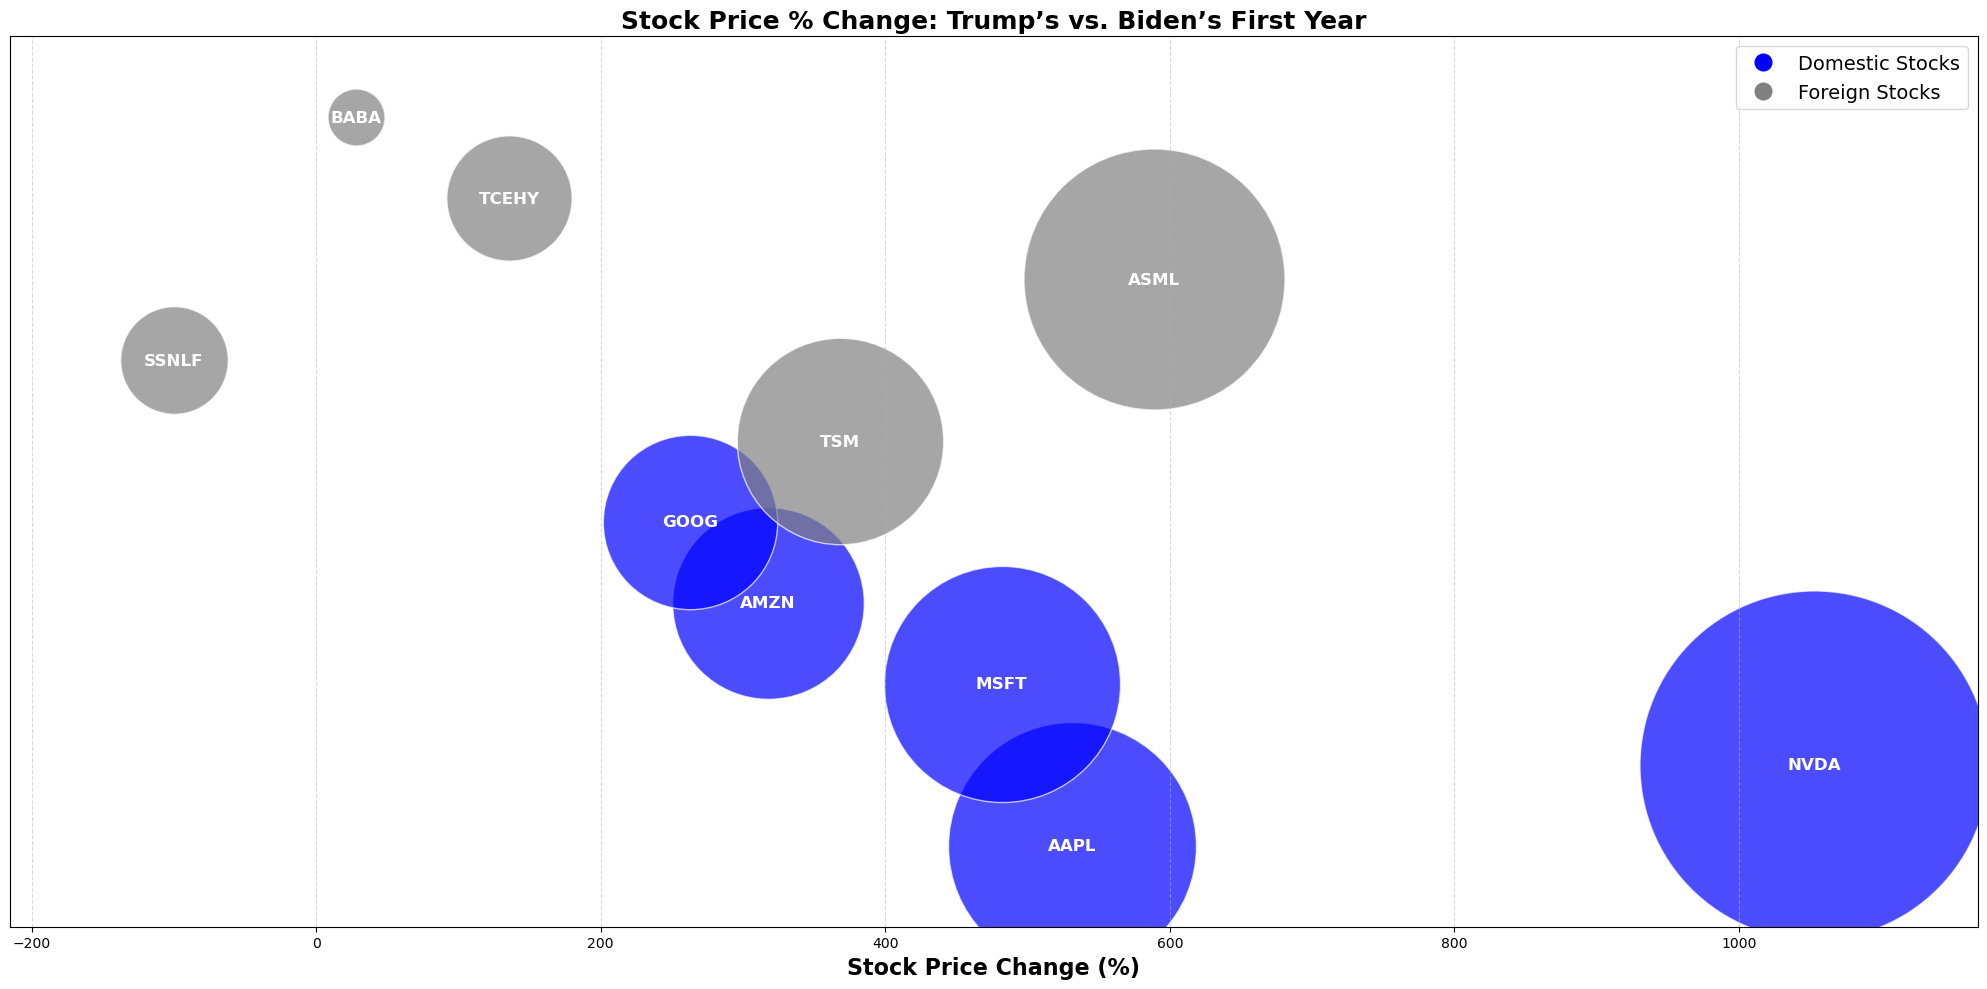

In [37]:
# Spread out the bubbles on the Y-axis to prevent overlap
df["y_offset"] = np.linspace(1, len(df), len(df))  

# Assign colors
colors = {"US": "blue", "International": "gray"}
bubble_colors = [colors[region] for region in df["Region"]]

# Scale bubble sizes
sizes = abs(df["% Change"]) * 60  # Bigger bubbles for visibility

# Create a Matplotlib Figure (Adjusted for better aspect ratio)
fig, ax = plt.subplots(figsize=(20, 10))  # Reduce width slightly to prevent compression

# Plot bubbles
for i, (ticker, x, y, size, color) in enumerate(zip(df["Ticker"], df["% Change"], df["y_offset"], sizes, bubble_colors)):
    ax.scatter(x, y, s=size, color=color, edgecolors='white', alpha=0.7)
    ax.text(x, y, ticker, fontsize=12, ha='center', va='center', color='white', fontweight='bold')

# Labels and formatting
ax.set_xlabel("Stock Price Change (%)", fontsize=16, fontweight="bold")
ax.set_title("Stock Price % Change: Trump’s vs. Biden’s First Year", fontsize=18, fontweight="bold")
ax.set_yticks([])  # Hide y-axis labels
ax.grid(True, linestyle="--", alpha=0.5)

# Custom legend for US vs. International stocks
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Domestic Stocks', markersize=12, markerfacecolor='blue', markeredgecolor="blue"),
    Line2D([0], [0], marker='o', color='w', label='Foreign Stocks', markersize=12, markerfacecolor='gray', markeredgecolor="gray")
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=14)

# Ensure all bubbles fit within the figure
ax.margins(0.1)  # Adds margin around the bubbles
plt.ylim(df["y_offset"].min() - 1, df["y_offset"].max() + 1)  # Expands Y limits

# Use tight layout to prevent clipping
plt.tight_layout()

# Save the figure with proper bounding
plt.savefig("bubblechart.png", dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()